# Анализ оттока клиентов фитнес-центра

**Цель исследования**

Провести анализ и подготовить план действий по удержанию клиентов.

**Задачи**

- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    1) выделить целевые группы клиентов;
    2) предложить меры по снижению оттока;
    3) определить другие особенности взаимодействия с клиентами.

**Ход исследования**

1. Загрузка данных;
2. Исследовательский анализ данных (EDA);
3. Построение модели прогнозирования оттока клиентов;
4. Кластеризация клиентов;
5. Общие выводы и рекомендации.

## Загрузка и обзор данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

In [2]:
try:
    df = pd.read_csv('C://Users//79199//Documents//Учёба//Аналитика//Сборные проекты//СП-11//gym_churn.csv')
except:
    df = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
display(df.head(15))
display(df.info())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

None

**Описание данных**

1. Данные клиента за предыдущий до проверки факта оттока месяц:
- `gender` — пол;
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
- `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- `Phone` — наличие контактного телефона;
- `Age` — возраст;
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).

2. Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
- `Group_visits` — факт посещения групповых занятий;
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- `Churn` — факт оттока в текущем месяце.

В датасете 4000 строк, пропущенных значений нет, тип данных исправления не требуют. Приведем названия столбцов к более удобному виду - сократим названия, приведем все к нижнему регистру.

In [4]:
# переименование столбцов
df = df.rename(columns={'gender':'gender',
                        'Near_Location':'location',
                        'Partner':'partner',
                        'Promo_friends':'promo',
                        'Phone':'phone',
                        'Age':'age',
                        'Lifetime':'lifetime',
                        'Contract_period':'contract_period',
                        'Month_to_end_contract':'month_to_end',
                        'Group_visits':'group_visits',
                        'Avg_class_frequency_total':'avg_cft',
                        'Avg_class_frequency_current_month':'avg_cfcm',
                        'Avg_additional_charges_total':'add_charges',
                        'Churn':'churn'})

In [5]:
df.columns.tolist()

['gender',
 'location',
 'partner',
 'promo',
 'phone',
 'contract_period',
 'group_visits',
 'age',
 'add_charges',
 'month_to_end',
 'lifetime',
 'avg_cft',
 'avg_cfcm',
 'churn']

Выводы: загрузили данные, убедились в отсутствии пропусков, привели названия столбцов к более удачному виду.

## EDA

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
add_charges,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Визуализируем распределения признаков:

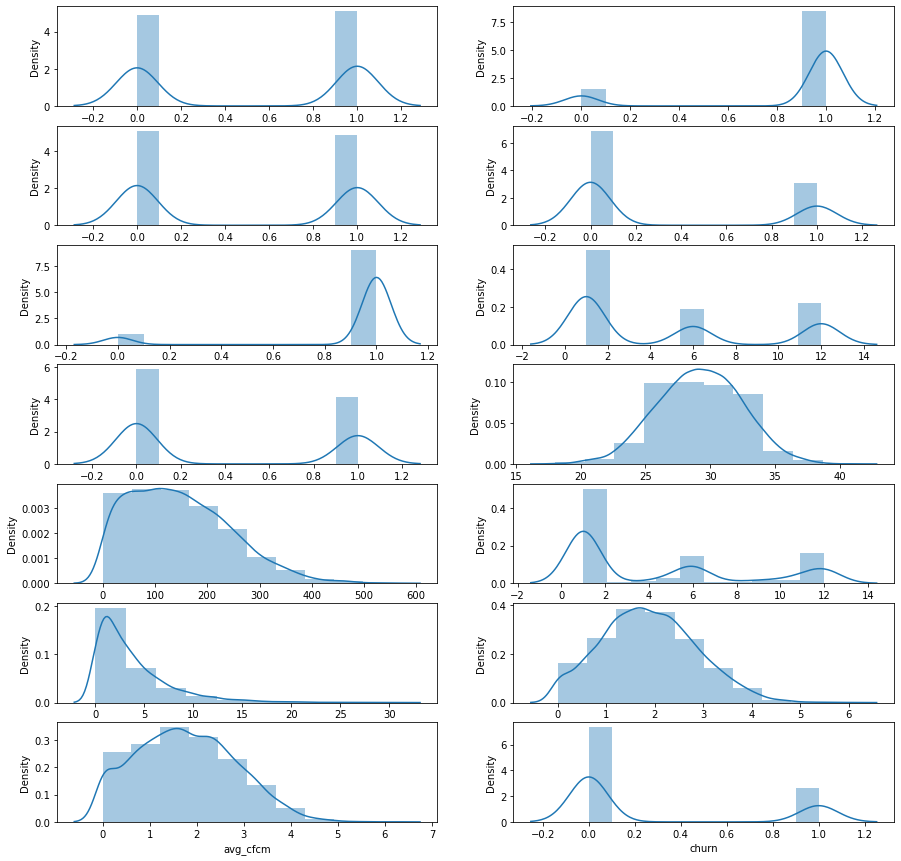

In [8]:
# распределение признаков
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15, 15))

for ax, column in zip(axes.ravel(), df.columns):
    sns.distplot(df[column], bins=10, ax=ax)

#for feature in df.columns:
    #sns.distplot(df[feature], bins=10)
    #plt.show() 

Средние значения признаков:
- пол: фитнес-центр посещает равное количество мужчин и женщин;
- местоположение: 84% клиентов проживают поблизости;
- почти половина клиентов являются сотрудниками компании-партнера;
- около 30% пришли по акции "приведи друга";
- 90% клиентов оставили свой телефон;
- средняя продолжительность контрактов - один месяц либо полгода;
- 41% клиентов посещают групповые занятия;
- средний возраст - 29 лет, плюс-минут 3 года; максимальный возраст - 41 год;
- в среднем клиенты тратят почти 150 (р.?) в месяц на доп. траты, плюс-минус 96 (р.?)
- до конца контракта 4 месяца, лайфтайм 3,7 месяца, среднее посещение в неделю - ок. 2 раз, отток 27%.
- среднее время до окончания действующего абонемента - чуть больше 4 месяцев;
- среднее время с момента первого посещения фитнес-центра - почти 4 месяца;
- средняя частота посещений за всё время - чуть менее двух раз в неделю, плюс-минус одно посещение в неделю;
- средняя частота посещений за последний месяц - почти такая же, как за всё время. Возможно, один из признаков следует удалить, так как их значения почти полностью совпадают;
- в отток попало ок. 30% клиентов.

In [9]:
# средние значения признаков ушедших и оставшихся
df.groupby('churn').agg('mean').T

churn,0,1
gender,0.510037,0.510839
location,0.873086,0.768143
partner,0.534195,0.355325
promo,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
add_charges,158.445715,115.082899
month_to_end,5.283089,1.662582


- отток среди мужчин и женщин одинаков;
- среди оставшихся несколько больше тех, кто живет поблизости;
- клиенты-партнеры остаются чаще, чем остальные клиенты;
- пришедшие по промоакции остаются в два раза чаще, чем пришедшие без акции;
- средний срок контракта у оставшихся - ближе к полугоду, средний срок у ушедших - ок. двух месяцев, т.е. среди них преобладают купившие абонемент на месяц;
- посещающие групповы занятия остаются в два раза чаще;
- оставшиеся в среднем почти на три года старше ушедших (почти 30 против почти 27 лет);
- оставшиеся тратят больше денег на доп.услуги, чем ушедшие;
- среднее время до окончания контракта у оставшихся - чуть более 5 месяцев, у ушедших - чуть более 1,5 месяцев;
- оставшиеся в среднем посещади клуб 4,7 месяца, ушедшие - значительно меньше, всего месяц;
- среднее количество посещений: у оставшихся стабильно два раза в неделю, как за всё время, так и за последний месяц; у ушедших - около полутора раз в неделю за все время, ближе к уходу падает до одного раза в неделю.

<Figure size 360x360 with 0 Axes>

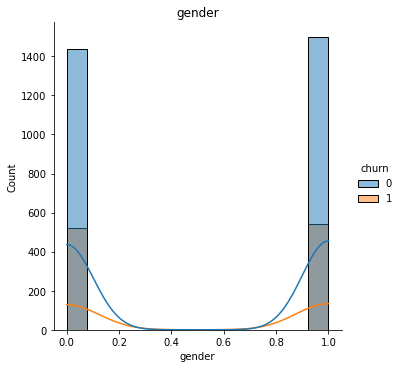

<Figure size 360x360 with 0 Axes>

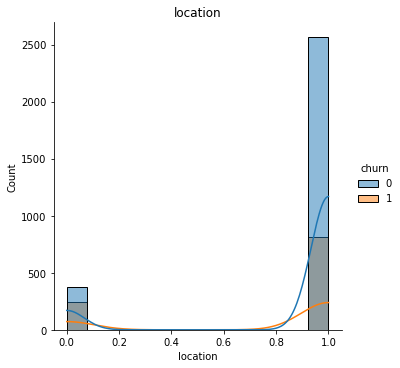

<Figure size 360x360 with 0 Axes>

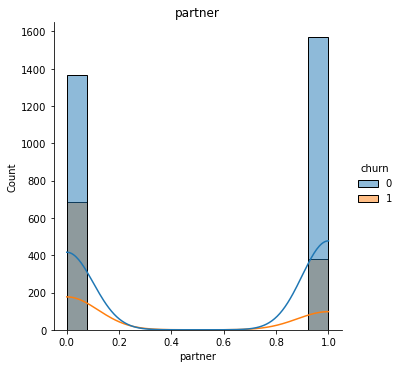

<Figure size 360x360 with 0 Axes>

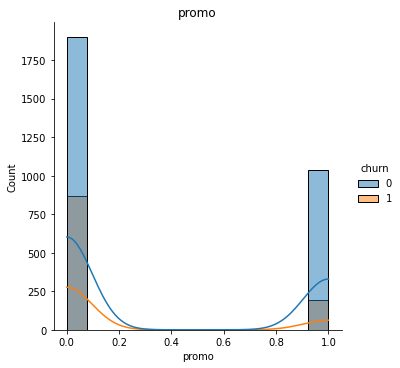

<Figure size 360x360 with 0 Axes>

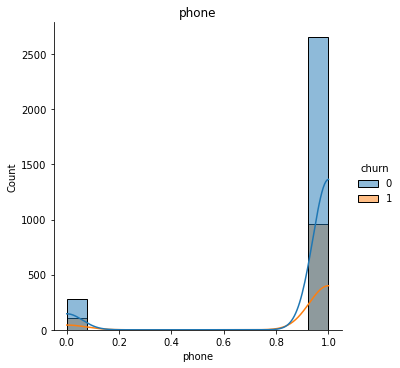

<Figure size 360x360 with 0 Axes>

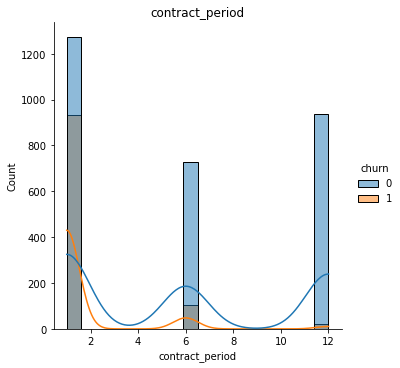

<Figure size 360x360 with 0 Axes>

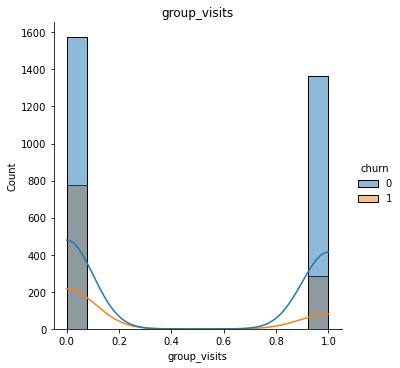

<Figure size 360x360 with 0 Axes>

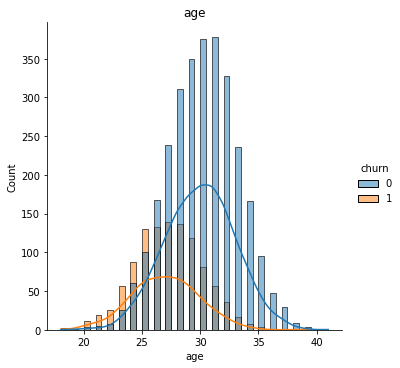

<Figure size 360x360 with 0 Axes>

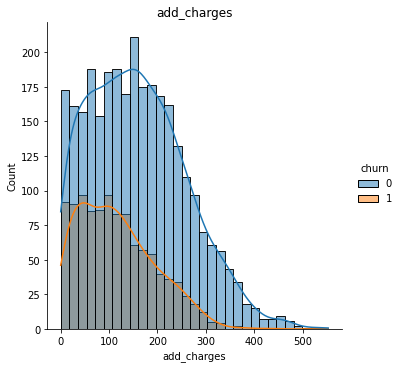

<Figure size 360x360 with 0 Axes>

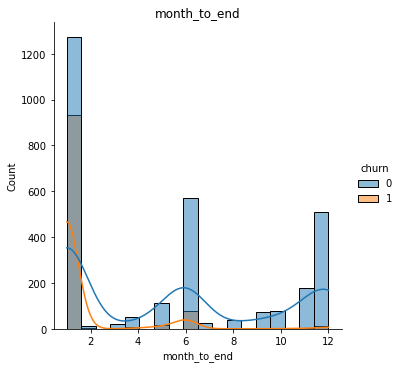

<Figure size 360x360 with 0 Axes>

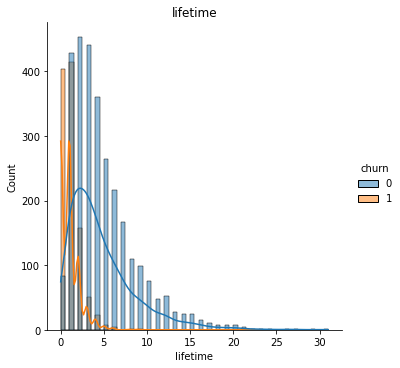

<Figure size 360x360 with 0 Axes>

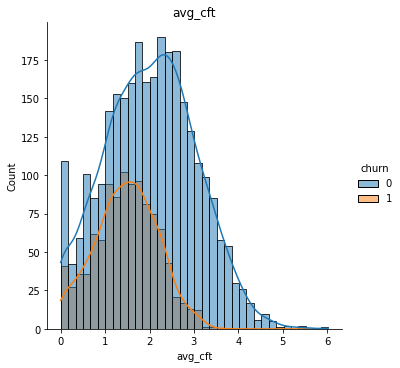

<Figure size 360x360 with 0 Axes>

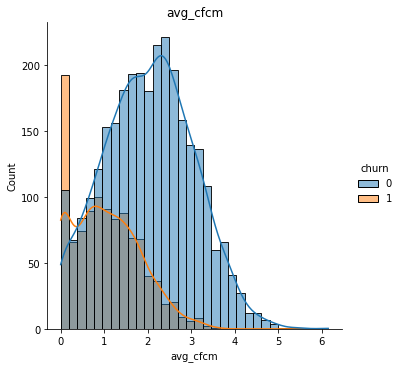

<Figure size 360x360 with 0 Axes>

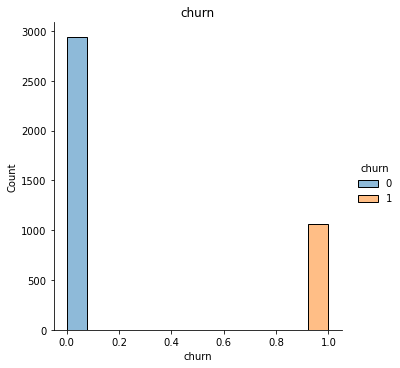

In [10]:
warnings.simplefilter(action='ignore', category=FutureWarning)

for column in df.columns:
    plt.figure(figsize=(5, 5))
#df.groupby('churn')
    sns.displot(x = df[column], hue='churn', data=df, kde = True)
    plt.title(column)
    plt.show()

Выводы: признаки "возраст", среднее количество посещений соответствуют нормальному распределению; доп. траты и лайфтайм скорее напоминают распределения Пуассона.

In [11]:
# матрица корреляций
rs = np.random.RandomState(0)
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,gender,location,partner,promo,phone,contract_period,group_visits,age,add_charges,month_to_end,lifetime,avg_cft,avg_cfcm,churn
gender,1.00,0.01,-0.01,-0.01,-0.01,0.00,0.02,0.01,-0.01,-0.00,0.01,0.01,0.01,0.00
location,0.01,1.00,-0.01,0.21,-0.02,0.15,0.15,0.06,0.04,0.14,0.07,0.04,0.06,-0.13
partner,-0.01,-0.01,1.00,0.45,0.01,0.31,0.02,0.05,0.02,0.29,0.06,0.02,0.05,-0.16
promo,-0.01,0.21,0.45,1.00,0.00,0.24,0.12,0.05,0.04,0.24,0.07,0.03,0.05,-0.16
phone,-0.01,-0.02,0.01,0.00,1.00,-0.01,-0.01,-0.01,0.01,-0.01,-0.02,0.01,0.01,-0.00
contract_period,0.00,0.15,0.31,0.24,-0.01,1.00,0.17,0.14,0.11,0.97,0.17,0.10,0.16,-0.39
group_visits,0.02,0.15,0.02,0.12,-0.01,0.17,1.00,0.08,0.03,0.16,0.08,0.06,0.08,-0.18
age,0.01,0.06,0.05,0.05,-0.01,0.14,0.08,1.00,0.08,0.13,0.16,0.12,0.18,-0.40
add_charges,-0.01,0.04,0.02,0.04,0.01,0.11,0.03,0.08,1.00,0.11,0.08,0.04,0.08,-0.20
month_to_end,-0.00,0.14,0.29,0.24,-0.01,0.97,0.16,0.13,0.11,1.00,0.16,0.09,0.15,-0.38


<AxesSubplot:>

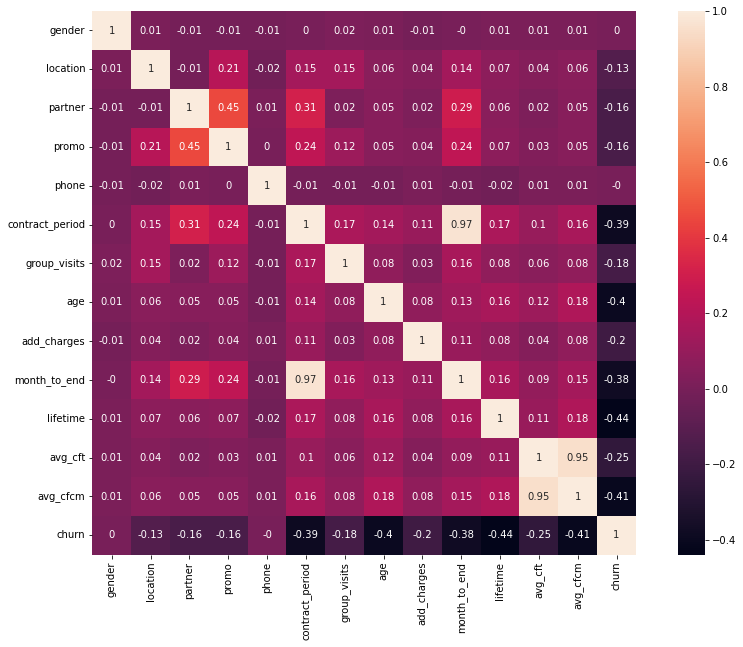

In [12]:
# более наглядный вариант

plt.figure(figsize=(15, 10))

corr = df.corr().round(2)

sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           annot=True,
           square=True
           )

Выводы: сильно коррелирующих (коэфф. корреляции > 0.8) с целевой переменной признаков нет.
Есть дублирующие друг друга данные: 1) длительность абонемента-количество месяцев до конца абонемента (contract_period-month_to_end), 2) количество посещений в неделю за всё время и в последний месяц (avg class frequency total - avg class frequency month). Их лучше удалить.

In [13]:
# удаление взаимозависимых признаков
#df.drop('Feature_2', axis = 1, inplace = True)
df.drop( 'month_to_end', axis = 1, inplace = True)
df.drop('avg_cfcm', axis = 1, inplace = True)

## Модель прогнозирования оттока клиентов

In [14]:
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

In [15]:
# разделим данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('churn', axis=1)
y = df['churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# обучаем StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# Преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state=0)

# обучим модель
lr_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]

# выведем все метрики
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)

# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)

# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

# выведем все метрики
print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities,
    title='Метрики для модели случайного леса:'
)

Метрики для модели логистической регрессии:
	Accuracy: 0.89
	Precision: 0.81
	Recall: 0.78
	F1: 0.79
	ROC_AUC: 0.96
Метрики для модели случайного леса:
	Accuracy: 0.89
	Precision: 0.82
	Recall: 0.75
	F1: 0.79
	ROC_AUC: 0.95


У случайного леса лучше точность предсказания, в то время как у логистической регрессии выше полнота. Если смотреть по всем метрикам, логистическая регрессия лучше.

<AxesSubplot:xlabel='churn', ylabel='Density'>

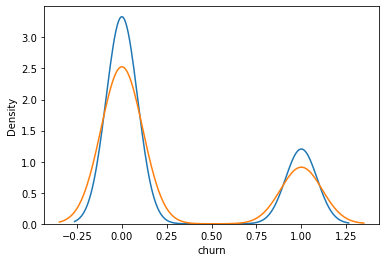

In [16]:
# гистограммы целевой переменной на обучающей и валидационной выборках
sns.kdeplot(y_train)
sns.kdeplot(y_test)

test и train достаточно близки.

## Кластеризация клиентов

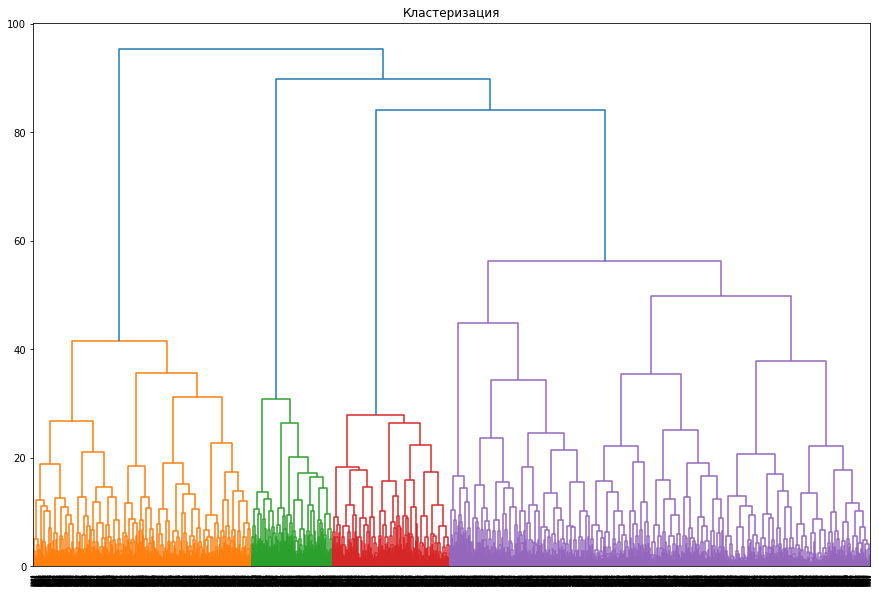

In [17]:
scaler = StandardScaler() # создаём объект класса scaler
df_2 = df.drop(columns=['churn'])
df_2
x_sc = scaler.fit_transform(df_2) # обучаем нормализатор и преобразуем набор данных

linked = linkage(x_sc, method='ward')

plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Кластеризация')
plt.show()

km = KMeans(n_clusters=5, random_state=0)

labels = km.fit_predict(x_sc)

# добавим к датафрейму столбец с кластерами
df['cluster_km'] = labels

Модель выделила четыре кластера. Проанализируем их.

In [18]:
# средние значения признаков по кластерам
df.groupby('cluster_km').mean().T

cluster_km,0,1,2,3,4
gender,0.499109,0.488571,0.505300,0.544202,0.523316
location,0.000000,0.995238,1.000000,1.000000,0.862694
partner,0.488414,0.955238,0.238516,0.250287,0.471503
promo,0.076649,0.892381,0.059187,0.079219,0.305699
phone,1.000000,1.000000,1.000000,1.000000,0.000000
contract_period,3.032086,7.660952,2.819788,4.528129,4.777202
group_visits,0.235294,0.458095,0.000000,1.000000,0.427461
age,28.721925,29.543810,28.770318,29.536165,29.297927
add_charges,137.540009,155.861428,143.383993,148.088897,144.208179
lifetime,3.060606,4.380952,3.343640,3.761194,3.940415


Выводы: В первый и второй кластеры попали клиенты с наименьшей долей оттока. Это клиенты:
- "старшей группы" (29-30 лет),
- отличающиеся высоким кровнем доп.трат,
- проживающие поблизости от фитнес-центра,
- купившие абонемент на полгода,
- обратившиеся в клуб 4-5 месяцев назад,
- посещающие клуб ок. двух раз в неделю;
- половина из них посещает групповые занятия.
Эти выводы по большей части пересекаются с выводами, сделанными на этапе исследовательского анализа данных.

In [19]:
# клиентов в каждом кластере
df.cluster_km.value_counts()

2    1132
1    1050
3     871
0     561
4     386
Name: cluster_km, dtype: int64

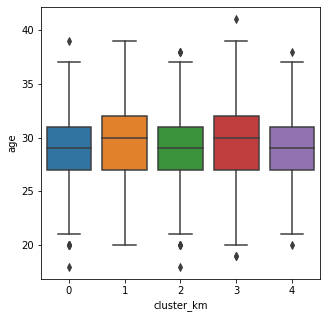

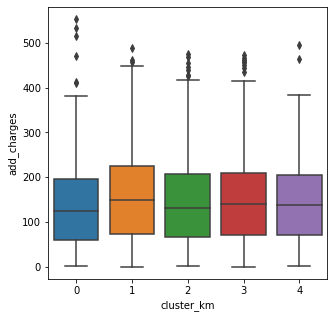

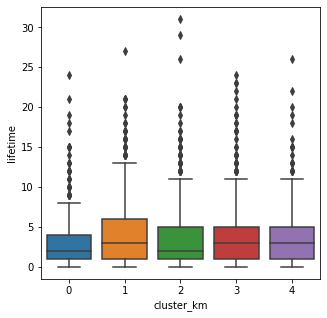

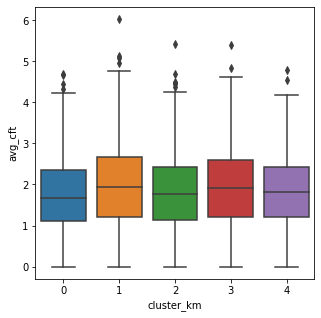

In [20]:
# распределения количественных признаков по кластерам
for column in ['age', 'add_charges', 'lifetime', 'avg_cft']:
    plt.figure(figsize=(5, 5))
    sns.boxplot(x = 'cluster_km', y = df[column], data = df)
    plt.show()

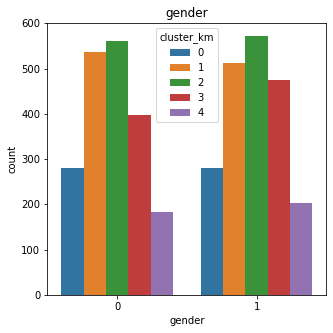

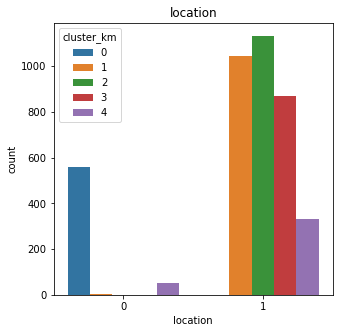

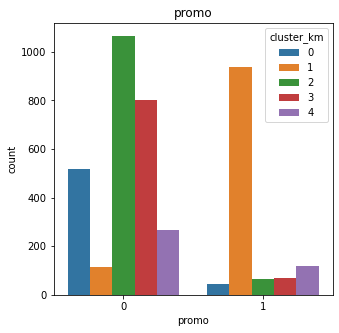

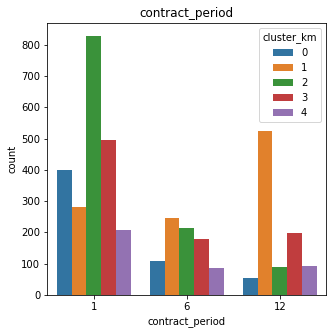

In [21]:
# распределения категориальных признаков по кластерам
for column in ['gender', 'location', 'promo', 'contract_period']:
    plt.figure(figsize=(5, 5))
    sns.countplot(x = df[column], hue='cluster_km', data=df)
    plt.title(column)
    plt.show()

Выводы: подтверждают предыдущие.

- первый и второй кластеры (с наименьшим оттоком) - клиенты, живущие поблизости от клуба, старше 29 лет, имеющие абонемент на 6 или 12 месяцев;
- третий кластер (отток более половины) имеет абонемент с наименьшьим сроком действия, не посещает групповые занятия, вкллючает клиентов до 29 лет, имеет лайфтайм короче, чем у остальных кластеров.

## Общие выводы и рекомендации

**Итоги**


В рамках исследования была проведена предварительная обработка и исследовательских анализ данных. Были сделаны выводы, что фитнес-центр посещает одинаковое количество мужчин и женщин, имеющие возраст в среднем 29 лет (+- 3 года), большинство проживает поблизости. Клиенты предпочитают брать абонемент на месяц или полгода, около 41% посещают групповые занятия. В среднем клиенты посещают фитнес-центр 2 раза в неделю.

В ходе кластеризации были выделены следующие группы клиентов:
1) Первый и второй кластены (отображены на дендрограмме фиолетовым и красным цветами соответственно): наиболее многочисленные (1003 и 971 клиент) и наименее подвержены оттоку. Это клиенты старше 29 лет, проживают поблизости от фитнес-центра, обладатели абонементов на полгода, посещающие фитнес-центр не менее 4-5 месяцев, стабильно 2 раза в неделю; большинство из них посещает групповые занятия и тратят на доп.услуги больше, чем остальные. Как правило это люди, являющиеся сотрудниками компаний-партнеров, и/или пришедшие по акции "приведи друга".

2) Третий и четвертый кластеры (оранжевый и зеленый цвета на дендрограмме): вместе составляют чуть более половины от суммы первых двух; здесь сосредоточен самый большой процент оттока. Это "младшие" клиенты (меньше 29 лет), купившие абонемент на месяц и посещающие фитнес-центр менее двух раз в неделю. Как правило если такой клиент начинает появляться в клубе один раз в неделю и реже - это означает, что вскоре он уйдет в отток. Такие клиенты реже посещают групповые занятия и меньше тратят на доп.услуги.

**Рекомендации**

Взаимодействие с клиентами имеет смысл вести в двух направлениях:

1) делать ставку на клиентов постарше (вне зависимости от пола) и платежеспособных (готовых посещать доп.занятия и тратиться в фитнес-центре на доп.услуги); продолжать и расширять сотрудничество с компаниями, как "поставщиками" самых лояльных клиентов.

2) учитывая, что в отток уходят самые молодые клиенты, можно поработать прицельно с этой аудиторией с целью ее удержания:
- организовать групповые занятия (фактор, уменьшающий отток), ориентированные именно на молодую аудиторию;
- придумать альтернативу компаниям-партнерам (например, заключать аналогичные договоры с колледжами и вузами);

Одним из значимых факторов, предсказывающих отток клиента - то, что он начинает реже посещать фитнес-центр. Можно придумать какие-то символические "плюшки" за регулярное посещение: бесплатный кофе\протеиновые батончики (сеанс массажа, уходовая процедура и пр.) для тех, кто стабильно ходит два раза в неделю в течение месяца, например.

В отток уходят преимущественно люди, живущие далеко от фитнес-центра - есть смысл рассмотреть вариант открытия нескольких точек, чтобы расширить охват.